## Imports

In [1]:
import numpy as np
import torch

## Configuration

In [2]:
from omegaconf import OmegaConf

CONFIG = OmegaConf.create({
    # Dataset
    "num_classes": 10,

    # Mean and std for normalization
    "normalize_mean": [0.4914, 0.4822, 0.4465],
    "normalize_std": [0.2023, 0.1994, 0.2010],

    # Model
    "model": "WideResNet-28-10-torchdistill",
    "dropout_rate": 0.3,

    # OPeN
    "pure_noise_image_size": 32,
    "pure_noise_mean": [0.4914, 0.4822, 0.4465],
    "pure_noise_std": [0.2023, 0.1994, 0.2010],

    # BN
    "noise_bn_option": "DARBN",

    # Histogram
    "pure_noise_count": 1000,

    # Checkpoint
    "checkpoint_filename": "CIFAR10IR100-open__epoch_199.pt",
})

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Download checkpoint

In [4]:
import os
import gdown
from storage import CHECKPOINT_URLS

checkpoint_filepath = f"checkpoints/{CONFIG.checkpoint_filename}"
if not os.path.exists(checkpoint_filepath):
    gdown.download(CHECKPOINT_URLS[CONFIG.checkpoint_filename], checkpoint_filepath, quiet=False)

## Set Random Seed

In [5]:
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Initialize Model

In [6]:
from initializers import initialize_model, InputNormalize
from models.noise_bn_option import NoiseBnOption

net = initialize_model(
    model_name=CONFIG.model, 
    num_classes=CONFIG.num_classes, 
    noise_bn_option=NoiseBnOption[CONFIG.noise_bn_option],
    dropout_rate=CONFIG.dropout_rate)
net = net.to(device)

normalizer = InputNormalize(
    torch.Tensor(CONFIG.normalize_mean).to(device), 
    torch.Tensor(CONFIG.normalize_std).to(device)
).to(device)

In [7]:
from checkpointing import load_checkpoint

load_checkpoint(net, optimizer=None, checkpoint_filepath=checkpoint_filepath)

In [8]:
net = net.eval()

## Generate Pure Noise Images

In [9]:
from replace_with_pure_noise import sample_noise_images

noise_images = sample_noise_images(
    image_size=CONFIG.pure_noise_image_size,
    mean=CONFIG.pure_noise_mean,
    std=CONFIG.pure_noise_std, 
    count=CONFIG.pure_noise_count,
)
noise_images = noise_images.to(device)

## Generate Predictions

In [10]:
with torch.no_grad():
    noise_images = normalizer(noise_images)
    noise_image_outputs = net(noise_images)
    _, predictions = torch.max(noise_image_outputs, 1)
    predictions_list = predictions.cpu().tolist()

In [11]:
from collections import Counter

predictions_counter = Counter(predictions_list)

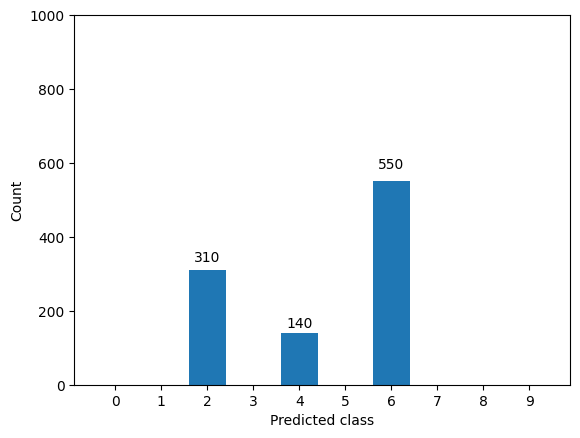

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bar = ax.bar(np.arange(CONFIG.num_classes), height=[predictions_counter[k] for k in np.arange(CONFIG.num_classes)])
ax.set_xticks(np.arange(CONFIG.num_classes))
ax.set_xlabel("Predicted class")
ax.set_ylabel("Count")

for rect in bar:
    height = rect.get_height()
    if height > 0:
        ax.text(rect.get_x() + rect.get_width()/2, 1.05*height, str(height), ha="center", va="bottom")
# ax.set_title(f"Histogram for {CONFIG.checkpoint_filename}")

ax.set_ylim(0, 1000)
fig.savefig("prior_histogram.png")
fig.show()